In [1]:
# !pip install tensorflow-gpu==1.9.0

  Could not find a version that satisfies the requirement tensorflow-gpu==1.9.0 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0rc0, 1.15.0rc1, 1.15.0rc2, 1.15.0rc3, 1.15.0, 1.15.2, 1.15.3, 2.0.0a0, 2.0.0b0, 2.0.0b1, 2.0.0rc0, 2.0.0rc1, 2.0.0rc2, 2.0.0, 2.0.1, 2.0.2, 2.1.0rc0, 2.1.0rc1, 2.1.0rc2, 2.1.0, 2.1.1, 2.2.0rc0, 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0)
No matching distribution found for tensorflow-gpu==1.9.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
# font_name
rc('font', family=font_name)

In [74]:
from tensorflow.keras.utils import to_categorical

In [3]:
train_dir = '최후의음식/train'
validation_dir = '최후의음식/test'

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 24000 files belonging to 30 classes.
Found 6089 files belonging to 30 classes.


In [72]:
a = [i for i in range(3)]
a

[0, 1, 2]

In [81]:
a = np.asarray(a)
len(to_categorical(a)[0])

3

In [79]:
[7]

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([ 7, 24, 16,  6,  1, 27, 29, 21, 19, 19, 20, 24, 21, 22, 17, 11, 24,
       20, 27,  8, 29, 21, 28,  7, 14, 21,  7, 21, 24,  1, 17,  4])>

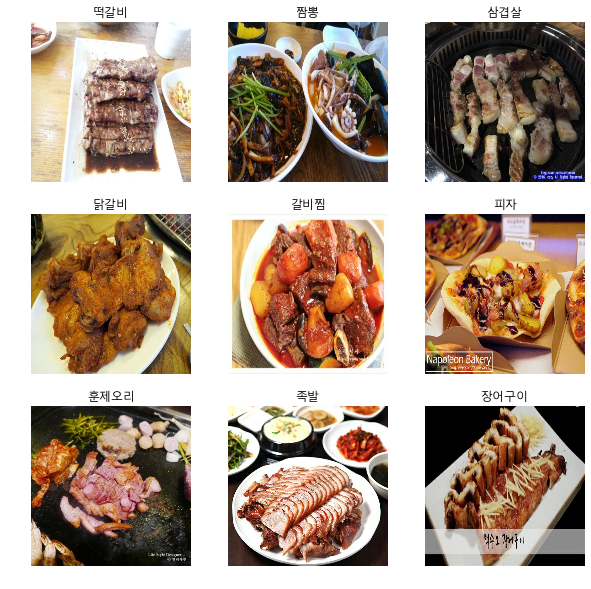

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5) 

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 153
Number of test batches: 38


In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

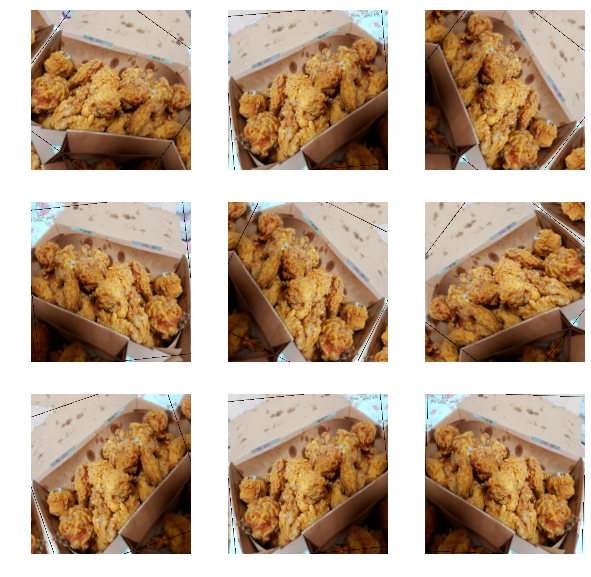

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [11]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(30)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 30)


In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
model.output_shape

(None, 30)

In [29]:
dir(tf.keras.losses)

['BinaryCrossentropy',
 'CategoricalCrossentropy',
 'CategoricalHinge',
 'CosineSimilarity',
 'Hinge',
 'Huber',
 'KLD',
 'KLDivergence',
 'LogCosh',
 'Loss',
 'MAE',
 'MAPE',
 'MSE',
 'MSLE',
 'MeanAbsoluteError',
 'MeanAbsolutePercentageError',
 'MeanSquaredError',
 'MeanSquaredLogarithmicError',
 'Poisson',
 'Reduction',
 'SparseCategoricalCrossentropy',
 'SquaredHinge',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'binary_crossentropy',
 'categorical_crossentropy',
 'categorical_hinge',
 'cosine_similarity',
 'deserialize',
 'get',
 'hinge',
 'huber',
 'kl_divergence',
 'kld',
 'kullback_leibler_divergence',
 'log_cosh',
 'logcosh',
 'mae',
 'mape',
 'mean_absolute_error',
 'mean_absolute_percentage_error',
 'mean_squared_error',
 'mean_squared_logarithmic_error',
 'mse',
 'msle',
 'poisson',
 'serialize',
 'sparse_categorical_crossentropy',
 'squared_hinge']

In [43]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([28, 24,  2, 15,  7, 25, 24,  0, 19, 26, 17, 24, 26, 25, 19,  2, 16,
       19, 11, 15,  6, 10, 18,  3,  4, 26, 29,  5, 21,  8, 23, 11])>

In [88]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [89]:
 model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [90]:
len(model.trainable_variables)

2

In [91]:
initial_epochs = 10

In [92]:
model.evaluate(validation_dataset)

153/153 [==============================] - 48s 315ms/step - loss: 3.4012 - accuracy: 0.0222


[3.4011731147766113, 0.022162938490509987]

In [93]:
loss0, accuracy0 = model.evaluate(validation_dataset)

153/153 [==============================] - 48s 312ms/step - loss: 3.4012 - accuracy: 0.0226


In [94]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.40
initial accuracy: 0.02


In [95]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
750/750 [==============================] - 288s 384ms/step - loss: 3.6618 - accuracy: 0.0335 - val_loss: 3.4779 - val_accuracy: 0.0392
Epoch 2/10
750/750 [==============================] - 287s 383ms/step - loss: 3.6737 - accuracy: 0.0451 - val_loss: 3.3266 - val_accuracy: 0.0445
Epoch 3/10
750/750 [==============================] - 287s 382ms/step - loss: 3.5583 - accuracy: 0.0501 - val_loss: 3.1536 - val_accuracy: 0.0464
Epoch 4/10
750/750 [==============================] - 287s 383ms/step - loss: 3.3684 - accuracy: 0.0545 - val_loss: 3.2226 - val_accuracy: 0.0466
Epoch 5/10
750/750 [==============================] - 287s 383ms/step - loss: 3.3565 - accuracy: 0.0517 - val_loss: 3.1835 - val_accuracy: 0.0472
Epoch 6/10
750/750 [==============================] - 286s 382ms/step - loss: 3.3611 - accuracy: 0.0665 - val_loss: 3.1339 - val_accuracy: 0.0648
Epoch 7/10
750/750 [==============================] - 287s 383ms/step - loss: 3.7261 - accuracy: 0.3083 - val_loss: 3.5999 -

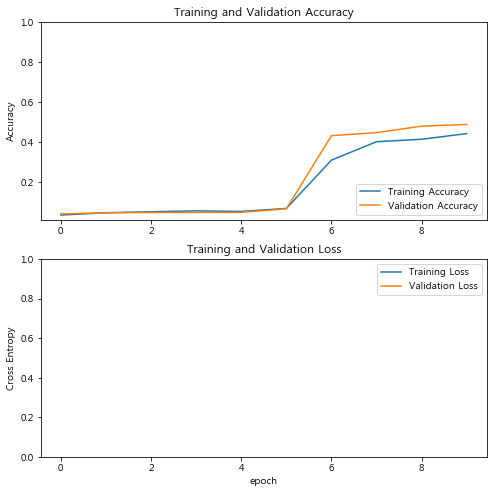

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [97]:
base_model.trainable = True

In [98]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [102]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [103]:
 model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [104]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
750/750 [==============================] - 417s 556ms/step - loss: 3.7652 - accuracy: 0.3488 - val_loss: 3.4005 - val_accuracy: 0.2838
Epoch 11/20
750/750 [==============================] - 412s 550ms/step - loss: 3.4012 - accuracy: 0.2156 - val_loss: 3.3998 - val_accuracy: 0.3029
Epoch 12/20
750/750 [==============================] - 413s 550ms/step - loss: 3.3959 - accuracy: 0.2282 - val_loss: 3.3956 - val_accuracy: 0.3084
Epoch 13/20
750/750 [==============================] - 413s 551ms/step - loss: 3.4002 - accuracy: 0.2175 - val_loss: 3.3963 - val_accuracy: 0.3501
Epoch 14/20
750/750 [==============================] - 416s 555ms/step - loss: 3.3912 - accuracy: 0.2779 - val_loss: 3.3949 - val_accuracy: 0.3277
Epoch 15/20
750/750 [==============================] - 417s 556ms/step - loss: 3.3703 - accuracy: 0.2779 - val_loss: 3.3844 - val_accuracy: 0.2947
Epoch 16/20
750/750 [==============================] - 416s 555ms/step - loss: 3.3799 - accuracy: 0.2353 - val_loss: 3

In [105]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



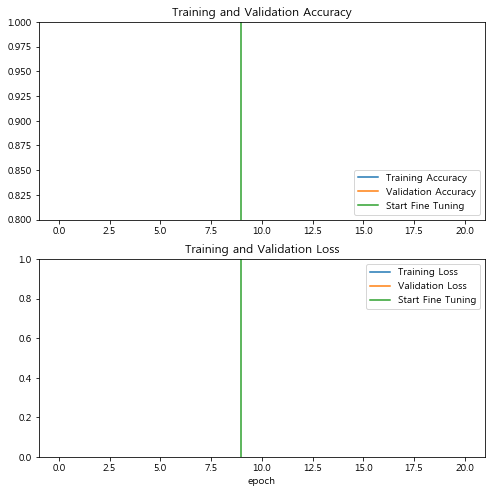

In [106]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [107]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

38/38 [==============================] - 12s 317ms/step - loss: 3.3928 - accuracy: 0.2237
Test accuracy : 0.22368420660495758


Predictions:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 

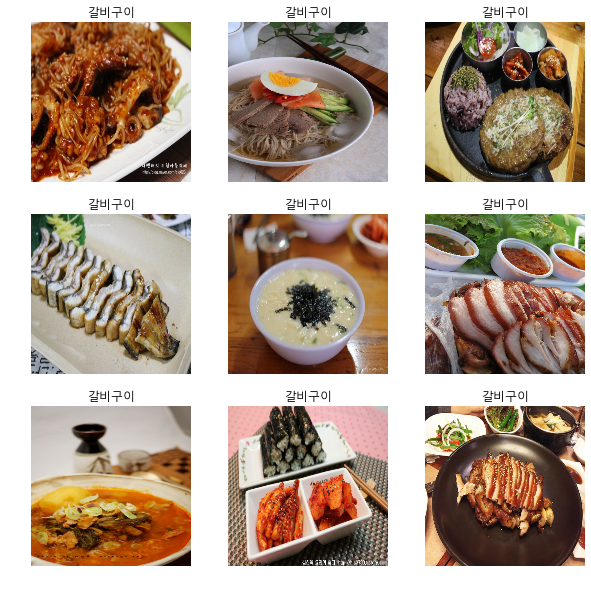

In [108]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")